# Part 1: Implementing Word Embeddings

After reviewing the article by Kashyap Kathrani comparing several popular embedding models (see reference [1]), I chose to work with **BERT** embeddings for this task. 

## Embedding Choice

We use **BERT (Bidirectional Encoder Representations from Transformers)** to generate word embeddings. BERT produces contextual embeddings which means the vector for a word can change depending on the sentence it's used in. This allows BERT to differentiate between meanings and uses of the same word.

### Why BERT?

- **Contextual Embeddings**: BERT captures the meaning of a word based on surrounding context
- **OOV Handling**: BERT uses subword tokenization so it can break down unfamiliar or rare words into known components and still produce usable embeddings (see reference [2]).
- **Benchmark Performance**: BERT outperforms older embeddings across many tasks such as classification and semantic similarity.

### Why Not Word2Vec, GloVe, or FastText?

- **Word2Vec** and **GloVe** produce static embeddings and cannot distinguish between different meanings of the same word. These models are also unable to handle OOV words
- **FastText** uses subword n-grams and can estimate vectors for unseen words, but it still produces static vectors.

We will use a pre-trained BERT model via the Hugging Face `transformers` library (see reference [3]).

In [ ]:
# Imports
from transformers import BertTokenizer, BertModel

# Load BERT model and tokenizer (see reference [3])
print("Loading BERT tokenizer and model")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set model to inference mode (see reference [4])
print("BERT model loaded.")


Loading BERT tokenizer and model
BERT model loaded.


In [20]:
# Imports 
import torch

# Function to get embedding for a single word (averages subword tokens) # see reference [5]
def get_word_embedding(word, tokenizer, model):
    tokens = tokenizer.tokenize(word)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor([token_ids])

    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs.last_hidden_state

    embedding = hidden_states[0].mean(dim=0)  # Average over token embeddings
    return embedding

# Prompt for user input
word1 = input("Enter the first word: ").strip().lower()
word2 = input("Enter the second word: ").strip().lower()

# Get embeddings
vec1 = get_word_embedding(word1, tokenizer, model)
vec2 = get_word_embedding(word2, tokenizer, model)

# Print first 10 dimensions of the vector for each world
print(f"\nEmbedding for '{word1}' (first 10 dimensions):\n{vec1[:10]}")
print(f"\nEmbedding for '{word2}' (first 10 dimensions):\n{vec2[:10]}")



Embedding for 'abcdge' (first 10 dimensions):
tensor([-0.2148, -0.2367,  0.2943, -0.3305,  0.2913, -0.2245,  0.1802, -0.6149,
        -0.1697,  0.3926])

Embedding for 'trees' (first 10 dimensions):
tensor([ 0.2581,  0.1369,  0.5647,  0.0375,  0.1261,  0.1396, -0.1132, -0.5971,
        -0.1743, -0.1629])


> This code handles non standard words by using BERT's subword tokenization. This breaks unknown words into known subword units and computes embeddings from those.

## Visualizing word embeddings

Cosine similarity is especially useful in word embeddings because it measures the angle between two word vectors, not their magnitude. Word embeddings (like BERT, Word2Vec, or FastText) represent semantic relationships as direction in multi-dimentional space so cosine similarity allows us to qunantify semantic closeness of words. For example, king and queen may have different lengths but they point in a similar direction because they are semantically related.

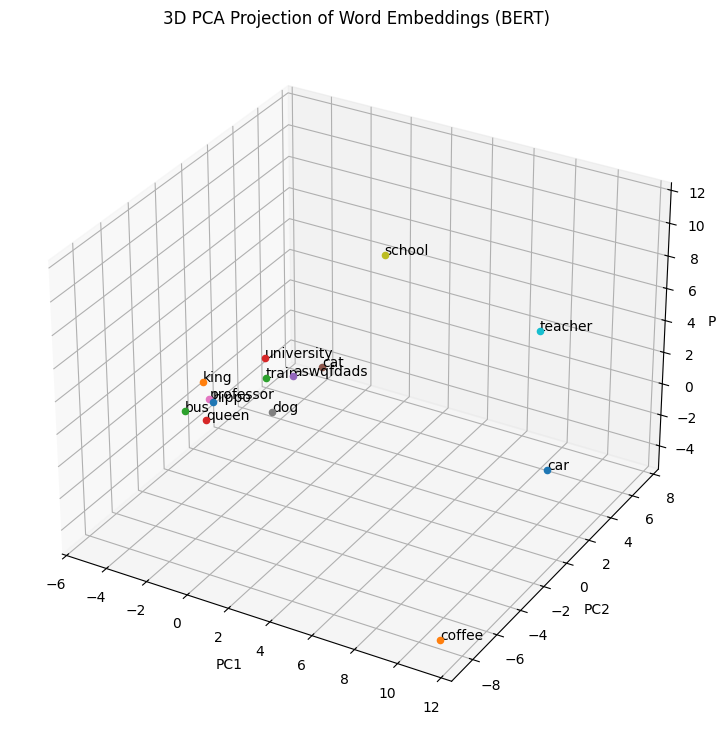


Cosine Similarities:
king <-> queen: 0.6095
cat <-> dog: 0.6345
coffee <-> car: 0.4006
aswqfdads <-> hippo: 0.4508
train <-> bus: 0.5133
teacher <-> professor: 0.2559
university <-> school: 0.3181


In [ ]:
# Imports
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity

# User input (Example:"king,queen;cat,dog;coffee,car;aswqfdads,hippo;train,bus;teacher,professor;university,school")
user_input = input("Enter word pairs (format: word1,word2;word3,word4;...): ")
pairs = [tuple(pair.strip().split(',')) for pair in user_input.strip().split(';')]

# Collect unique words and generate embeddings
unique_words = list(set([word for pair in pairs for word in pair]))
embeddings = {word: get_word_embedding(word, tokenizer, model) for word in unique_words}

# Reduce to 3D for visualization (see reference [7])
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform([embeddings[word] for word in unique_words])
word_coords = {word: reduced_vectors[i] for i, word in enumerate(unique_words)}

# Plot 3D scatter plot (see refrence [6])
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for word, (x, y, z) in word_coords.items():
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, size=10)

ax.set_title("3D PCA Projection of Word Embeddings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

# Print cosine similarities (see refrence [5])
print("\nCosine Similarities:")
for w1, w2 in pairs:
    sim = cosine_similarity([embeddings[w1]], [embeddings[w2]])[0][0]
    print(f"{w1} <-> {w2}: {sim:.4f}")


## Dissimilarity Metrics

In addition to some standard metrics, we will also use a metric called Cosine Scaled Euclidean Distance (CSED), which combines the strengths of both cosine similarity and Euclidean distance.

- **Cosine similarity** measures how aligned two word vectors are, but it ignores how far apart they are in space.
- **Euclidean distance** measures how far two vectors are, but not whether they point in a similar semantic direction.

### CSED?

By multiplying the Euclidean distance by `(1 - cosine similarity)`, the CSED metric takes both angle misalignment and spatial distance as penalties. This results in a more complete dissimilarity score that better captures situations where the words may be related in topic but distant in meaning/usage.




csed dissimilarity to 'cat':
dog: 4.3337
table: 7.0998
watermellon: 8.4583
videogame: 8.5856
abcd: 9.9996
tree: 10.8429
car: 10.9902


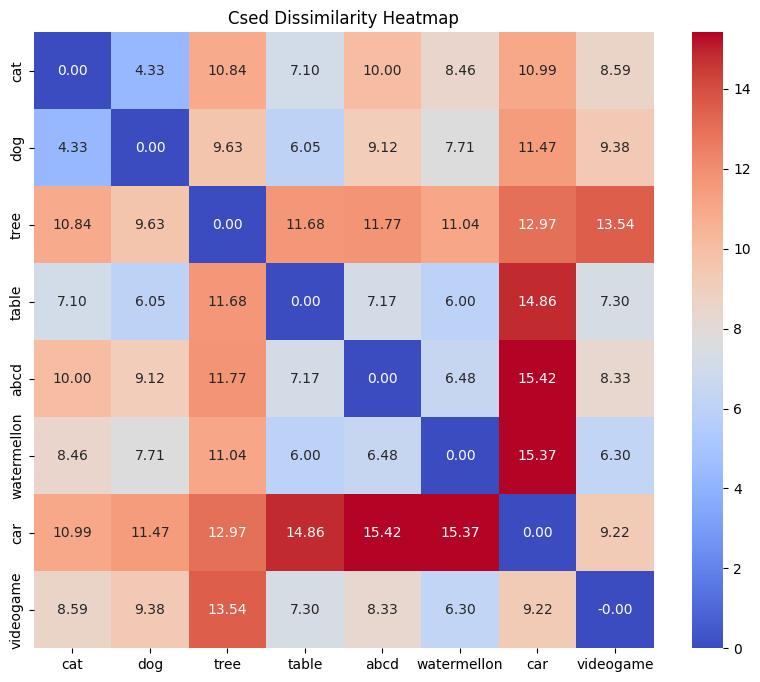

In [36]:
# Imports
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

# Cosine Scaled Euclidean Dissimilarity (CSED)
def csed(vec1, vec2):
    cos_sim = cosine_similarity([vec1], [vec2])[0][0]
    euc_dist = euclidean(vec1, vec2)
    return euc_dist * (1 - cos_sim)

# Metric Selector
def compute_metric(v1, v2, metric):
    if metric == "cosine":
        return 1 - cosine_similarity([v1], [v2])[0][0]  # convert similarity to dissimilarity
    elif metric == "euclidean":
        return euclidean(v1, v2) # (see reference[8])
    elif metric == "csed":
        return csed(v1, v2)
    else:
        raise ValueError("Unsupported metric. Currenty able to use [cosine | euclidean |csed]")

# User Input
# Example: 
# cat
# dog, lion, tiger, table, happiness
# csed
anchor_word = input("Enter anchor word: ").strip().lower()
comparison_input = input("Enter comparison words (Format: word1,word2,word3,word4,...)").strip().lower()
metric_choice = input("Choose metric [cosine | euclidean | csed]: ").strip().lower()

comparison_words = [w.strip() for w in comparison_input.split(',')]
all_words = [anchor_word] + comparison_words

# Get Embeddings
embeddings = {word: get_word_embedding(word, tokenizer, model) for word in all_words}

# Ranking
scores = []
for word in comparison_words:
    dist = compute_metric(embeddings[anchor_word], embeddings[word], metric_choice)
    scores.append((word, dist))

sorted_scores = sorted(scores, key=lambda x: x[1])

print(f"\n{metric_choice} dissimilarity to '{anchor_word}':")
for word, score in sorted_scores:
    print(f"{word}: {score:.4f}")

# Heatmap of All Pairwise Scores (see reference [9])
matrix = np.zeros((len(all_words), len(all_words)))
for i, w1 in enumerate(all_words):
    for j, w2 in enumerate(all_words):
        matrix[i, j] = compute_metric(embeddings[w1], embeddings[w2], metric_choice)


plt.figure(figsize=(10, 8))
sns.heatmap(matrix, xticklabels=all_words, yticklabels=all_words, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"{metric_choice.capitalize()} Dissimilarity Heatmap")
plt.show()



COSINE Dissimilarity to 'cat'
dog: 0.3655
lion: 0.4066
happiness: 0.4174
tiger: 0.4661
table: 0.5243


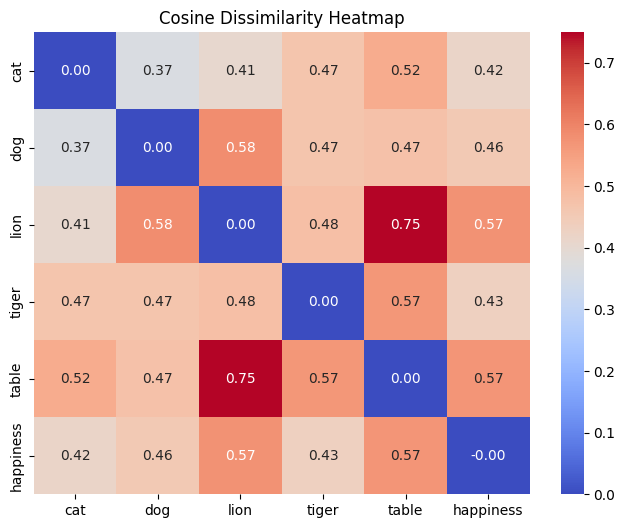


EUCLIDEAN Dissimilarity to 'cat'
dog: 11.8570
happiness: 12.4808
tiger: 12.6477
table: 13.5413
lion: 13.7463


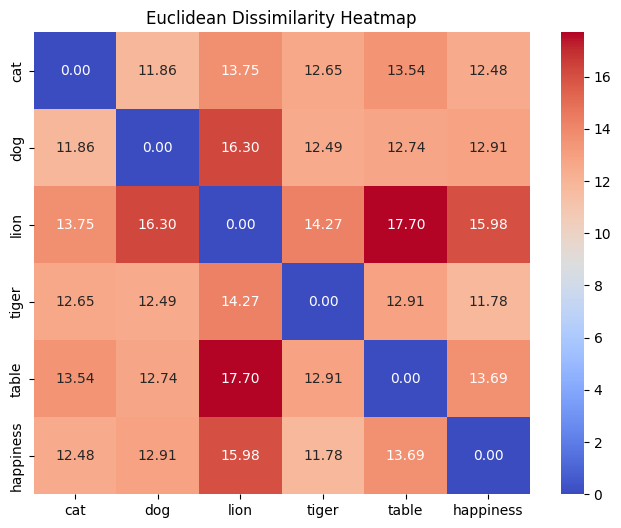


CSED Dissimilarity to 'cat'
dog: 4.3337
happiness: 5.2092
lion: 5.5891
tiger: 5.8950
table: 7.0998


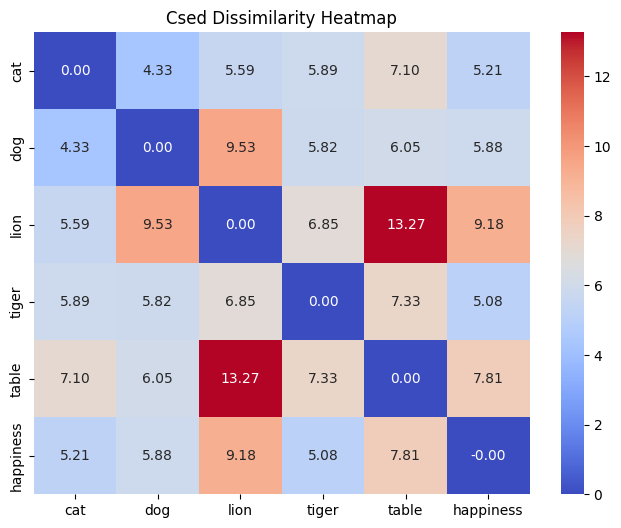

In [34]:
# Non user version for comaprison between euclidian, cosine, and CSED metrics
metrics = ["cosine", "euclidean", "csed"]
anchor_word = "cat"
comparison_words = ["dog", "lion", "tiger", "table", "happiness"]
all_words = [anchor_word] + comparison_words

# Get embeddings 
embeddings = {word: get_word_embedding(word, tokenizer, model) for word in all_words}

for metric_choice in metrics:
    print(f"\n{metric_choice.upper()} Dissimilarity to '{anchor_word}'")
    
    # Ranking
    scores = []
    for word in comparison_words:
        dist = compute_metric(embeddings[anchor_word], embeddings[word], metric_choice)
        scores.append((word, dist))

    sorted_scores = sorted(scores, key=lambda x: x[1])
    for word, score in sorted_scores:
        print(f"{word}: {score:.4f}")

    # Heatmap
    matrix = np.zeros((len(all_words), len(all_words)))
    for i, w1 in enumerate(all_words):
        for j, w2 in enumerate(all_words):
            matrix[i, j] = compute_metric(embeddings[w1], embeddings[w2], metric_choice)

    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, xticklabels=all_words, yticklabels=all_words, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"{metric_choice.capitalize()} Dissimilarity Heatmap")
    plt.show()


## References

1. Kathrani, K. (2020). *All About Embeddings*.  
   Retrieved from https://medium.com/@kashyapkathrani/all-about-embeddings-829c8ff0bf5b

2. Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*.  
   Retrieved from https://arxiv.org/abs/1810.04805

3. Hugging Face. (n.d.). *Transformers: Pretrained models*.  
   Retrieved from https://huggingface.co/docs/transformers/model_doc/bert

4. PyTorch. (n.d.). *torch.nn.Module — PyTorch Documentation*.  
   Retrieved from https://pytorch.org/docs/stable/generated/torch.nn.Module.html

5. GeeksforGeeks. (n.d.). *How to generate Word Embedding using BERT?*  
   Retrieved from https://www.geeksforgeeks.org/nlp/how-to-generate-word-embedding-using-bert/

6. Matplotlib. (n.d.). *Axes3D.scatter — mplot3d 3D scatter plot API documentation*.  
   Retrieved from https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.scatter.html#mpl_toolkits.mplot3d.axes3d.Axes3D.scatter

7. Bathula, C. P. (2023). *Comprehensive Exploration of NLP Word Embeddings, Word2Vec, and PCA in 3D*.  
   Retrieved from https://medium.com/@ChandraPrakash-Bathula/comprehensive-exploration-of-nlp-word-embeddings-word2vec-and-pca-in-3d-2d5d0858fd11

8. SciPy. (n.d.). *scipy.spatial.distance.euclidean — SciPy v1.11.4 Manual*.  
   Retrieved from https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html

9. Seaborn. (n.d.). *seaborn.heatmap — seaborn 0.11.1 documentation*.  
   Retrieved from https://seaborn.pydata.org/generated/seaborn.heatmap.html

